In [1]:
# %%
import numpy as np
from numpy.linalg import det, inv, norm
from numpy.random import normal
from scipy.optimize import minimize, Bounds, least_squares
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import random
from functools import cache

np.random.seed(23)
np.random.RandomState = 22
random.seed(22)
np.set_printoptions(precision=5)
plt.rcParams['figure.figsize'] = [10, 4]

# 1. Исходные данные

In [2]:
def F_(th_1):
    return np.matrix([[th_1, 0.55], [-0.1, 0.5]])
def PSI_(th_2):
    return np.matrix([1, th_2]).T
G = np.matrix([1, 1]).T
H = np.matrix([1, 0])
Q = np.matrix(0.1)
R = np.matrix(0.05)
x0 = np.matrix([0, 0]).T
P0 = np.matrix([[0.1, 0], [0, 0.1]])
I = np.eye(2)
N = 30 # Размерность сигнала U
s = 2 # Размерность th
th_true = np.array([-0.8, 1])
th_1_range = [-2, -0.05]
th_2_range = [0.01, 1.5]
U = np.matrix(np.ones(N+1)*5).T

# 2. Отклик

In [3]:
def make_Y(th, err=1, err2=1):
    X = np.matrix(np.zeros((2, N+1)))
    Y = np.matrix(np.zeros((N+1, 1)))
    F = F_(th[0])
    PSI = PSI_(th[1])
    X[:, 0] = x0
    Y[0] = H@X[:, 0] + normal(-np.sqrt(R)/2, np.sqrt(R))*err
    for k in range(1, N+1):
        wi = normal(-np.sqrt(R)/2, np.sqrt(Q), (1,2))*err
        vi = normal(-np.sqrt(Q)/2, np.sqrt(R))*err*err2
        X[:, k] = F@X[:, k-1] + PSI@U[k] + (G@wi)[0].T
        Y[k] = H@X[:, k] + vi
    return Y, X
Y, X = make_Y(th_true)

# 3. Критерий идентификации

In [4]:
def HI(th, Y):
    hi = N*np.log(2*np.pi)
    P_k_k = P0
    x_k_k = x0
    F = F_(th[0])
    PSI = PSI_(th[1])
    for k in range(N):
        P_k1_k = F@P_k_k@F.T + G@Q@G.T
        B_k1 = H@P_k1_k@H.T + R
        K_k1 = P_k1_k@H.T@inv(B_k1)
        P_k1_k1 = (I - K_k1@H)@P_k1_k
        x_k1_k = F@x_k_k + PSI@U[k]
        e_k1 = Y[k+1] - H@x_k1_k
        x_k_k = x_k1_k + K_k1@e_k1
        delta = e_k1.T@inv(B_k1)@e_k1
        hi += math.log(det(B_k1)) + delta
        P_k_k = P_k1_k1
    return np.float64(hi/2)

In [5]:
print(HI(np.array([-1.2, 1.81]), make_Y(np.array([-1.9, 0.81]), 0)[0])) 
print(HI(th_true, make_Y(th_true, 0)[0]))

5.6450990306036344e+16
0.05376917009959059


C:\Users\Mark\AppData\Local\Temp\ipykernel_14128\2177532428.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.float64(hi/2)


# 4. Градиент критерия

In [6]:
def gradHI(th, Y):
    dF = [np.matrix([[1,0],[0,0]]), np.matrix(np.zeros((2,2)))]
    dPSI = [np.matrix(np.zeros((2,1))), np.matrix([0,1]).T]
    dx0 = np.array([[[0],[0]],[[0],[0]]])
    # dG, dH, dQ, dR, dx0, dP0 - нулевые матрицы
    dHi = np.zeros(len(th))
    F = F_(th[0])
    PSI = PSI_(th[1])
    P_k_k = P0
    dP_k_k = [np.matrix(np.zeros((2,2))), np.matrix(np.zeros((2,2)))]
    x_k_k = x0
    dx_k_k = dx0
    for k in range(N):
        P_k1_k = F @ P_k_k @ F.T + G @ Q @ G.T
        B_k1 = H @ P_k1_k @ H.T + R
        K_k1 = P_k1_k @ H.T @ inv(B_k1)
        P_k1_k1 = (I - K_k1 @ H) @ P_k1_k
        dP_k1_k = [None, None]
        dB_k1 = [None, None]
        dK_k1 = [None, None]
        dx_k1_k1 = [None, None]
        for i in range(s):
            dP_k1_k[i] = dF[i] @ P_k_k @ F.T + F @ dP_k_k[i] @ F.T + F @ P_k_k @ dF[i].T
            dB_k1[i] = H @ dP_k1_k[i] @ H.T
            dK_k1[i] = (dP_k1_k[i] @ H.T - P_k1_k @ H.T @ inv(B_k1) @ dB_k1[i]) @ inv(B_k1)
            dP_k_k[i] = (I - K_k1 @ H) @ dP_k1_k[i] - dK_k1[i] @ H @ P_k1_k
        delta = np.zeros((s, 1))
        x_k1_k = F @ x_k_k + PSI @ U[k]
        e_k1 = Y[k+1] - H @ x_k1_k
        x_k1_k1 = x_k1_k + K_k1 @ e_k1
        for i in range(s):
            dx_k1_k = dF[i] @ x_k_k + F @ dx_k_k[i] + dPSI[i] @ U[k]
            de_k1 = -H @ dx_k1_k
            dx_k1_k1[i] = dx_k1_k + dK_k1[i] @ e_k1 + K_k1 @ de_k1
            delta[i] += float(
                de_k1.T @ inv(B_k1) @ e_k1 -
                1/2 * e_k1.T @ inv(B_k1) @ dB_k1[i] @ inv(B_k1) @ e_k1
            )
        dHi[i] += 1/2 * np.trace(inv(B_k1) @ dB_k1[i]) + delta[i]
        P_k_k = P_k1_k1
        x_k_k = x_k1_k1
        dx_k_k = dx_k1_k1
    return dHi

In [7]:
a = gradHI(np.array([-1.9, 1.81]), make_Y(np.array([-1.9, 0.81]), 0)[0]) 
print(type(a), a)

<class 'numpy.ndarray'> [  0.      960.57612]


C:\Users\Mark\AppData\Local\Temp\ipykernel_14128\780617284.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta[i] += float(
C:\Users\Mark\AppData\Local\Temp\ipykernel_14128\780617284.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dHi[i] += 1/2 * np.trace(inv(B_k1) @ dB_k1[i]) + delta[i]


In [44]:
th_est_m0 = [] 
th_est_m1 = [] 
Y_observation_list = [] 

for i in range(5): 
    Y_obs, _ = make_Y(th_true) 
    Y_observation_list.append(Y_obs) 
    
    th_0 = np.array([np.random.uniform(-2, -0.05), np.random.uniform(0.01, 1.5)]) 
    res_0 = minimize( 
        method="nelder-mead", 
        fun=HI, x0=th_0, 
        bounds=Bounds([-2, -0.05], [0.01, 1.5]), 
        options={"xatol": 1e-5, "fatol": 1e-5}, 
        tol=1e-5, 
        args=(Y_obs, ), 
    ) 
    res_1 = minimize( 
        method="SLSQP", 
        fun=HI, 
        x0=th_0, 
        jac=gradHI, 
        bounds=Bounds([-2, -0.05], [0.01, 1.5]), 
        options={"eps": 1e-12, "ftol": 1e-12},
        tol=1e-12, 
        args=(Y_obs, ), 
    )
    print(f"th0: {th_0}\tМ0: {res_0['x']} ({res_0['nit']}/{res_0['nfev']}) М1: {res_1['x']} ({res_1['nfev']}/{res_1['njev']}/{res_1['nit']})")
    th_est_m0.append(res_0['x']) 
    th_est_m1.append(res_1['x'])

th_est_m0 = np.array(th_est_m0) 
th_est_m1 = np.array(th_est_m1) 
th_est_m0 = np.mean(th_est_m0[:, 0]), np.mean(th_est_m0[:, 1]) 
th_est_m1 = np.mean(th_est_m1[:, 0]), np.mean(th_est_m1[:, 1])

print(f"Среднее по 5 наблюдениям\nM0: {th_est_m0}\nM1: {th_est_m1}")

C:\Users\Mark\AppData\Local\Temp\ipykernel_14128\2177532428.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.float64(hi/2)
C:\Users\Mark\AppData\Local\Temp\ipykernel_14128\780617284.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta[i] += float(
C:\Users\Mark\AppData\Local\Temp\ipykernel_14128\780617284.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dHi[i] += 1/2 * np.trace(inv(B_k1) @ dB_k1[i]) + delta[i]


th0: [-0.2642   0.63319]	М0: [-0.82168  0.92834] (53/100) М1: [-0.2642   0.39037] (3/2/2)
th0: [-0.16697  1.23528]	М0: [-0.6699   0.75031] (58/113) М1: [-0.16697  0.27039] (3/3/3)
th0: [-1.21986  0.26395]	М0: [-0.79881  0.92295] (56/109) М1: [-1.21986  1.33518] (3/3/3)
th0: [-1.84172  1.30328]	М0: [-1.40822  1.5    ] (31/57) М1: [-1.84172  1.5    ] (2/2/2)
th0: [-1.79328  1.05732]	М0: [-0.95009  1.05338] (58/112) М1: [-1.79328  1.5    ] (4/3/3)
Среднее по 5 наблюдениям
M0: (-0.9297382054116925, 1.0309949781881769)
M1: (-1.0572037530487461, 0.9991868323078965)


In [45]:
def mean(th): 
    Y_ = np.array([make_Y(th, 1, 0)[0] for _ in range(100)]) 
    return np.array([np.mean(np.array(Y_)[:, i]) for i in range(N+1)]).reshape(N+1) 
Y_mean_obs = np.array([np.mean(np.array(Y_observation_list)[:, i]) for i in range(N+1)])

Y_est_m0 = mean(th_est_m0) 
Y_est_m1 = mean(th_est_m1)

In [46]:
dth_m0 = norm(th_true - th_est_m0) / norm(th_true) 
dY_m0 = norm(Y_mean_obs - Y_est_m0) / norm(Y_mean_obs) 
dth_m1 = norm(th_true - th_est_m1) / norm(th_true) 
dY_m1 = norm(Y_mean_obs - Y_est_m1) / norm(Y_mean_obs) 
print("0-го порядка:") 
print(f"Ошибка в пространстве параметров: {dth_m0}") 
print(f"Ошибка в пространстве отклика: {dY_m0}") 
print("1го порядка:") 
print(f"Ошибка в пространстве параметров: {dth_m1}")
print(f"Ошибка в пространстве отклика: {dY_m1}")

0-го порядка:
Ошибка в пространстве параметров: 0.10415950074440847
Ошибка в пространстве отклика: 0.08662472879813557
1го порядка:
Ошибка в пространстве параметров: 0.2008433921875447
Ошибка в пространстве отклика: 0.4182540280129996


C:\Users\Mark\AppData\Local\Temp\ipykernel_14128\113000924.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


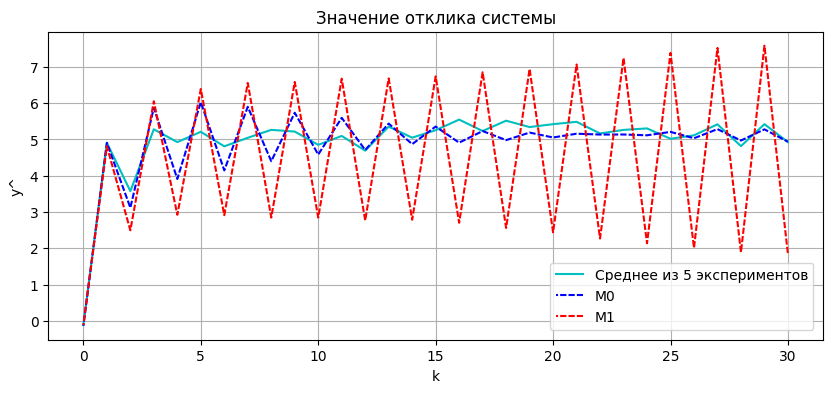

In [47]:
_x = list(range(len(Y_mean_obs))) 
plt.close('all') 
fig, ax = plt.subplots() 
plt.title("Значение отклика системы") 
ax.set_ylabel("y^") 
ax.set_xlabel("k") 
ax.grid(True) 
ax.plot(_x, Y_mean_obs, color='c', linestyle='-', label='Среднее из 5 экспериментов')
ax.plot(_x, Y_est_m0, color='b', linestyle=(2, (3, 1)), label='M0') 
ax.plot(_x, Y_est_m1, color='r', linestyle=(2, (3, 1)), label='M1') 
fig.legend(loc="upper left", bbox_to_anchor=(0.62,0.32)); 
fig.show()